In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')
df_test = pd.read_csv('F:/Titanic/data/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

In [5]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

In [6]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test


In [7]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

In [8]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [9]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

In [10]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

In [11]:
# test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [12]:
del(df_train['PassengerId'])
del(df_test['PassengerId'])

In [13]:
df_train, df_test = names(df_train, df_test)
df_train, df_test = age_impute(df_train, df_test)
df_train, df_test = cabin_num(df_train, df_test)
df_train, df_test = cabin(df_train, df_test)
df_train, df_test = embarked_impute(df_train, df_test)
df_train, df_test = fam_size(df_train, df_test)
df_test['Fare'].fillna(df_train['Fare'].mean(), inplace = True)
df_train, df_test = ticket_grouped(df_train, df_test)

In [14]:
import h2o

In [17]:
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 46 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_hamza_85va53
H2O cluster total nodes:,1
H2O cluster free memory:,5.166 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [18]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'Pclass', u'Sex', u'Age', u'Fare', u'Embarked', u'Name_Len', u'Name_Title', u'Age_Null_Flag', u'Cabin_num_[2, 28.667]', u'Cabin_num_(28.667, 65.667]', u'Cabin_num_(65.667, 148]', u'Cabin_Letter', u'Fam_Size', u'Ticket_Lett', u'Ticket_Len']


In [19]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [20]:
def model_performance(model):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()



In [21]:
nfolds =7

In [22]:
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=150,
                                      max_depth=5,
                                      min_rows=3,
                                      learn_rate=0.01,
                                      nfolds=7,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm",)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.948571749888
valid accuracy: 0.886875206885


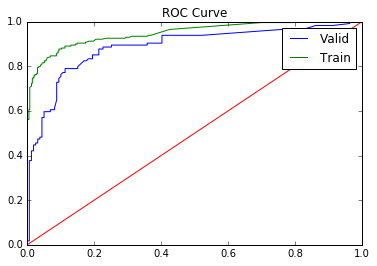

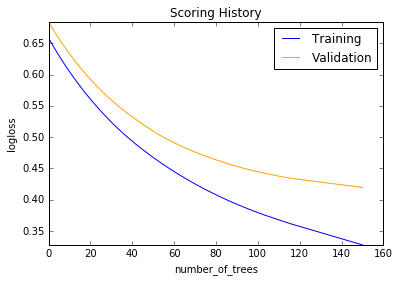

In [23]:
model_performance(my_gbm)
my_gbm.plot()

In [24]:
# Train and cross-validate a GBM
my_gbm1 = H2OGradientBoostingEstimator(ntrees=250,
                                      max_depth=90,
                                      min_rows=30,
                                      learn_rate=0.005,
                                      nfolds=7,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm1",)
my_gbm1.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.924915654521
valid accuracy: 0.914128875648


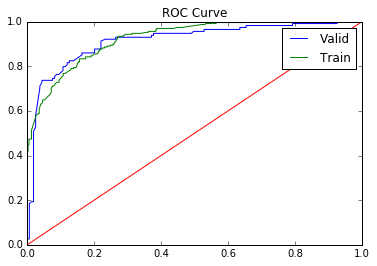

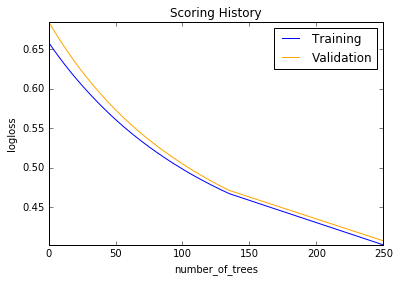

In [25]:
model_performance(my_gbm1)
my_gbm1.plot()

In [26]:
# Train and cross-validate a DL
my_dl = H2ODeepLearningEstimator(seed =1,  
                                 overwrite_with_best_model = False,
                                 model_id="my_dl",
                              hidden=[200,200,200],
                              epochs =45,
                              l2= 1e-20,
#                               l1=1e-2,
                                 rate = 0.01,
#                                  momentum_start = 0.5,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=7,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
my_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.917352676563
valid accuracy: 0.859593953437


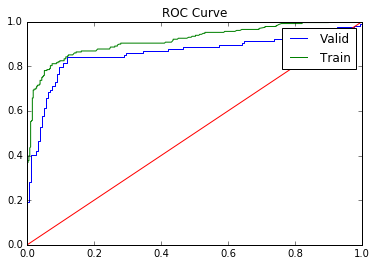

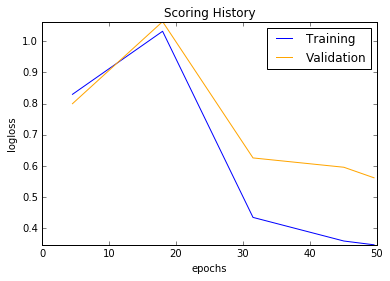

In [27]:
model_performance(my_dl)
my_dl.plot()

In [28]:
# ensemble both above models to improve accuracy
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [29]:
# Train a stacked ensemble using the GBM and DL above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble",
                                       base_models=[my_gbm.model_id, my_gbm1.model_id])
ensemble.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Train accuracy: 0.943404183536
valid accuracy: 0.91103939093


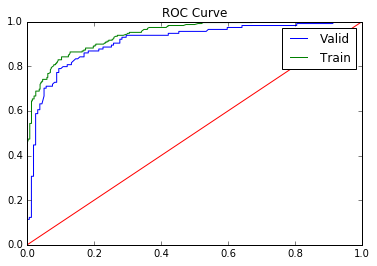

In [30]:
model_performance(ensemble)


## Predict with Model 

In [31]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
def get_prediction(model, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [39]:
df_submission = get_prediction(my_gbm1,hdf_data=hdf_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [40]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)

In [35]:
# df_submission.head()

In [36]:
# h2o.shutdown()